Version 1, créée par M. Dayé
16072023
EEIA 2023

## TP:  Modèles de probabilité: La régression Logistique
### Choix du mode de transport entre la voiture et la moto à l'aide de la régression logistique

Dans cette étude de cas, nous allons utiliser des données fictives sur le choix du mode de transport entre la voiture et la moto, puis  prédire la probabilité de choisir l'un ou l'autre mode à partir des conditions de circulation. Vous disposez d'une base de données synthétique nommée *choix_modal_nonencodé.csv*

L'objectif de ce TP est d'estimer un modèle de régression logistique de la forme $Prob((voiture=1)/X)=f(Distance, temps, heure de pointe)$ afin de permettre à l'apprenant de comprendre dans le fond cette méthode de classification largement utilisée en *Machine Learning* (ML) notamment. Ici nous ne ferons pas de ML au sens échantillon d'apprentissage/échantillon test, mais nous nous attèlerons à comprendre les foncdements statistiques du modèle et l'analyse de ses indicateurs de performance, en vue de sa bonne exploitation. Nous utiliserons essentiellement à cet effet 

### Tâche 1 : Charger les librairies nécessaires au travail

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
#from sklearn.model_selection import train_test_split
#from jyquickhelper import add_notebook_menu
#add_notebook_menu()

### Tâche 2: Importer et explorer la base de données 

In [2]:
## Importation des données
#data = pd.read_csv("choix_modal.csv",   sep=';')
data = pd.read_csv("choix_modal_nonencodé.csv",   sep=';')

## Exploration

data.head(5)
##
data.info()
#data.describe()
#data.describe(include=object)
data



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Distance     1000 non-null   float64
 1   temps        1000 non-null   object 
 2   HeurePointe  1000 non-null   int64  
 3   ChoixMode    1000 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 31.4+ KB


,Distance,temps,HeurePointe,ChoixMode
0,21.197606,ensoleillé,0,voiture
1,9.298041,pluvieux,1,moto
2,7.578692,ensoleillé,0,moto
3,16.988128,pluvieux,0,voiture
4,21.864600,ensoleillé,0,moto
...,...,...,...,...
995,8.667526,ensoleillé,0,voiture
996,21.036546,pluvieux,0,voiture
997,11.067236,ensoleillé,0,voiture
998,1.120886,pluvieux,0,moto


#### Tâche 3 : Quelle est la distribution effective du choix modal (choix voiture et choix de moto) en fonction du temps qu'il fait (probabilité conditionnelle de choix modal) ? 
Indice: Une possibilité est de faire un tableau croisé

In [3]:
pd.crosstab(data.ChoixMode, data.temps, margins=True, margins_name="Total")

temps,ensoleillé,pluvieux,Total
ChoixMode,,,
moto,222,211,433
voiture,287,280,567
Total,509,491,1000


In [4]:
pd.crosstab(data.ChoixMode, data.temps, normalize='columns', margins=True).round(2)*100

temps,ensoleillé,pluvieux,All
ChoixMode,,,
moto,44.0,43.0,43.0
voiture,56.0,57.0,57.0


#### Tâche 4: Représenter graphiquement le choix modal (part modale des motos et celle des voitures dans la base)

ChoixMode
moto       43.3
voiture    56.7
dtype: float64

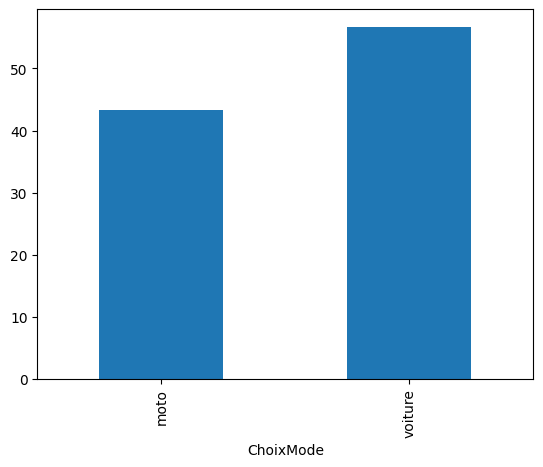

In [5]:

# Generating a bar chart for a single column
#%matplotlib inline
#GroupedData_mode=data.groupby(by='ChoixMode').size()
GroupedData_mode=data.groupby(by='ChoixMode').size()/(1000)*100
GroupedData_mode.plot.bar()

GroupedData_mode

#### Tâche 5: En vue de préparer les variables pour estimer le modèle, encoder les variables qualitative binaire *ChoixMode* (appeler la nouvelle  variable binaire *voiture* avec voiture=1 si voiture et 0 sinon) et *temps* (appeler la nouvelle  variable binaire *pluvieux* avec pluveux=1 si temps pluvieux et 0 sinon)

In [6]:
data['Voiture'] = 1 * (data['ChoixMode'] =="voiture")
data['pluvieux'] = 1 * (data['temps'] =="pluvieux")

data

,Distance,temps,HeurePointe,ChoixMode,Voiture,pluvieux
0,21.197606,ensoleillé,0,voiture,1,0
1,9.298041,pluvieux,1,moto,0,1
2,7.578692,ensoleillé,0,moto,0,0
3,16.988128,pluvieux,0,voiture,1,1
4,21.864600,ensoleillé,0,moto,0,0
...,...,...,...,...,...,...
995,8.667526,ensoleillé,0,voiture,1,0
996,21.036546,pluvieux,0,voiture,1,1
997,11.067236,ensoleillé,0,voiture,1,0
998,1.120886,pluvieux,0,moto,0,1


#### Tâche 6a: Représenter un nuage de points entre la variable *ChoixMode* (en ordonnée) et la variable *Distance*

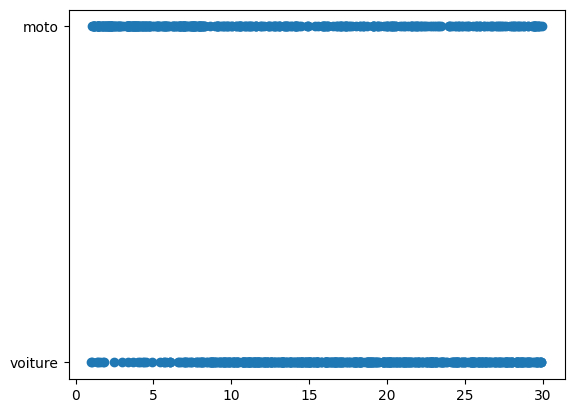

In [7]:
#%matplotlib inline
plt.scatter(data.Distance, data.ChoixMode)

#### Tâche 6b: Ajouter la droite d'ajustement linéaire au nuage de points entre le choix modal et la distance. Vous pourriez utiliser la fonction *regplot()* de la librairie *seaborn*. Commenter la nature de la relation entre le choix modal et la distance à parcourir.

<Axes: xlabel='Distance', ylabel='Voiture'>

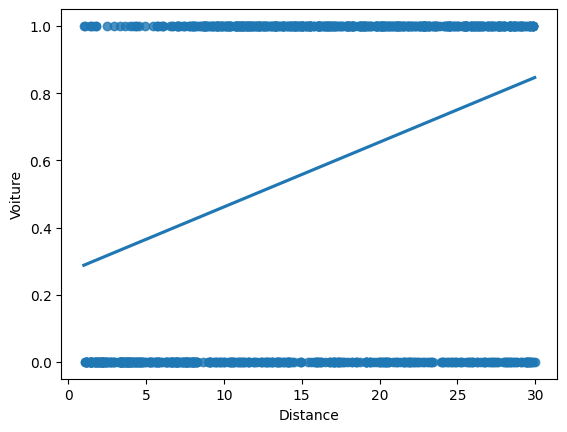

In [8]:
sns.regplot(x=data.Distance, y=data.Voiture, ci=False)

Nous voulons prédire  la probabilité de choisir la voiture comme moyen de déplacement entere le Domicile et le lieu de travail en fonction des conditions de déplacement.

$Prob((voiture=1)/X)=f(Distance, temps, heure de pointe)$

#### Tâche 7: Estimer cette probabilité par les Moindres Carrés Ordinaires (MCO), c'est à dire estimez un modèle de régression linéaire.

Nous voulons prédire  la probabilité de choisir la voiture comme moyen de déplacement Domicile Travail en fonction des caractéristiques de l'individu et du temps qu'il fait et de la distance. 

Créer dans un premier temps un vecteur *y* contenant la variable dépendante (cible) et *X* une matrice contenant les variables explicatives (caractéristiques)

In [9]:
# Séparer les données en variables explicatives (X) et variable cible (y)
X = data[['Distance','pluvieux', 'HeurePointe']]
y = data[['Voiture']]

X 
y

,Voiture
0,1
1,0
2,0
3,1
4,0
...,...
995,1
996,1
997,1
998,0


Estimation du modèle par MCO: utiliser la fonction *OLS()* de la librairie *statsmodels*

In [10]:
model_mco = sm.OLS(y, X)
results_mco = model_mco.fit()
# Avec  statsmodel, on a une sortie qui ressemble beaucoup à celle de R ou autres logiciels purement statistiques
print(results_mco.summary())

                                 OLS Regression Results                                
Dep. Variable:                Voiture   R-squared (uncentered):                   0.659
Model:                            OLS   Adj. R-squared (uncentered):              0.658
Method:                 Least Squares   F-statistic:                              641.8
Date:                Sun, 16 Jul 2023   Prob (F-statistic):                   3.11e-232
Time:                        23:03:47   Log-Likelihood:                         -597.54
No. Observations:                1000   AIC:                                      1201.
Df Residuals:                     997   BIC:                                      1216.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [11]:
lin_reg=LinearRegression(fit_intercept=False).fit(X, y)
print("Coefficients", lin_reg.coef_)

Coefficients [[ 0.03520608  0.11062769 -0.49312209]]


##### Prédire la probabilité de choisir la voiture à partir du modèle estimé et étant donné la matrice des caractéristiques X. Inclure ce vecteur de probabilités prédite (y_pred) dans la base de donnée contenant l'ensemble des variables. Ensuite classer ces probabilités telles que 
Si $ProbPrédite(voiture=1/X)>50\%$,  alors le choix modal prédit par le modèle pour l'individu est la voiture, sinon, c'est la moto pour effectuer son déplacement.
Calculer le pourcentage de probabilités prédites abbérantes(>1 ou <0>), le pourcentage de classification correcte parmi les probabilités prédites définies et le pourcentage de classification incorrecte. 

In [12]:
data['y_pred']= results_mco.predict(X)
data['prob_pred_aberr'] = np.where((data.y_pred < 0) | (data.y_pred >1) , 'Aberrante', 'Définie')
#pd.crosstab(index=data['prob_pred_abber'], columns='Count')
pd.crosstab(index=data['prob_pred_aberr'], columns='%')*100/1000

col_0,%
prob_pred_aberr,
Aberrante,16.8
Définie,83.2


In [13]:
data_pred=data[(data['prob_pred_aberr']=='Définie')]
data_pred

,Distance,temps,HeurePointe,ChoixMode,Voiture,pluvieux,y_pred,prob_pred_aberr
0,21.197606,ensoleillé,0,voiture,1,0,0.746285,Définie
2,7.578692,ensoleillé,0,moto,0,0,0.266816,Définie
3,16.988128,pluvieux,0,voiture,1,1,0.708713,Définie
4,21.864600,ensoleillé,0,moto,0,0,0.769767,Définie
5,13.270087,pluvieux,0,voiture,1,1,0.577815,Définie
...,...,...,...,...,...,...,...,...
995,8.667526,ensoleillé,0,voiture,1,0,0.305150,Définie
996,21.036546,pluvieux,0,voiture,1,1,0.851242,Définie
997,11.067236,ensoleillé,0,voiture,1,0,0.389634,Définie
998,1.120886,pluvieux,0,moto,0,1,0.150090,Définie


In [14]:
data_pred['y_pred_classes']=np.where(data_pred['y_pred']>0.5,'Voiture', 'Moto')
#check_class=data[['ChoixMode','Voiture','y_pred','prob_pred_aberr','y_pred_classes']]
check_class_pred=data_pred[['ChoixMode','Voiture','y_pred','prob_pred_aberr','y_pred_classes']]
check_class_pred

C:\Users\errep\AppData\Local\Temp\ipykernel_37704\2510372406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred['y_pred_classes']=np.where(data_pred['y_pred']>0.5,'Voiture', 'Moto')


,ChoixMode,Voiture,y_pred,prob_pred_aberr,y_pred_classes
0,voiture,1,0.746285,Définie,Voiture
2,moto,0,0.266816,Définie,Moto
3,voiture,1,0.708713,Définie,Voiture
4,moto,0,0.769767,Définie,Voiture
5,voiture,1,0.577815,Définie,Voiture
...,...,...,...,...,...
995,voiture,1,0.305150,Définie,Moto
996,voiture,1,0.851242,Définie,Voiture
997,voiture,1,0.389634,Définie,Moto
998,moto,0,0.150090,Définie,Moto


In [15]:
pd.crosstab(data.ChoixMode, data_pred.y_pred_classes, margins=True, margins_name="Total")

y_pred_classes,Moto,Voiture,Total
ChoixMode,,,
moto,269,79,348
voiture,151,333,484
Total,420,412,832


In [16]:
pd.crosstab(data.ChoixMode, data_pred.y_pred_classes, margins=True, margins_name="Total")*100/832 # Classification dans la limite des prob définies
pd.crosstab(data.ChoixMode, data_pred.y_pred_classes, margins=True, margins_name="Total")*100/1000 # classification dans l'ensemble

y_pred_classes,Moto,Voiture,Total
ChoixMode,,,
moto,26.9,7.9,34.8
voiture,15.1,33.3,48.4
Total,42.0,41.2,83.2


#### Tâche 8 : Estimer le modèle par Régression  Logistique en utilisant statmodels. Commenter les résultats.

In [17]:
# Estimer  le même modèle par une  régression logistique
model = sm.Logit(y, X)
resultat = model.fit()
print(resultat.summary())

Optimization terminated successfully.
         Current function value: 0.515025
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Voiture   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Jul 2023   Pseudo R-squ.:                  0.2472
Time:                        23:03:47   Log-Likelihood:                -515.02
converged:                       True   LL-Null:                       -684.14
Covariance Type:            nonrobust   LLR p-value:                 3.575e-74
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Distance        0.0790      0.007     11.743      0.000       0.066       0.092
pluvieux       -0.3753    

#### Tâche 9: Estimer le modèle en utilisant la librairie sklearn. Déterminer   le taux de prédictions correctes (score()).

In [18]:
Log_Reg = LogisticRegression(fit_intercept=False).fit(X,y)
print("Coefficients", Log_Reg.coef_)
Log_Reg.score(X,y)  ### Exactitude/Accuracy>>>>Taux de prédictions correctes

Coefficients [[ 0.076907   -0.36001955 -2.99470717]]


c:\Users\errep\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.753

#### Tâche 10: A l'aide d'une matrice de confusion déterminer la précision, la sensibilité et la spécificité de la capacité prédictive de notre modèle et son taux de faux positifs.
#### Quelques définitions d'indicateurs de performance de la classification

##### Matrice de confusion: c'est un tableau croisé entre la classification prédite (classe des positifs/classe des négatifs prédites par le modèle) et la classification réelle (classe des positifs/classe des négatifs effectivement observées). Il met en exergue les prédictions suivantes: *VP (Vrais Positifs), VN (Vrais Négatifs), FP (Faux Positifs) et FN (Faux Négatifs)*. Les notions  *positif* et *négatif* viennent de la médecine où il est courant de tester la présence ou non d'un antigène ou  d'une maladie dans le sang. Mais en classification binaire, on peut comprendre ces termes de façon plus générale en considérant le "positif" comme  étant la caractéristique que l'on souhaite prédire/détecter avec notre modèle et le  "négatif" comme représentant la caractéristique alternative (qui va donc marquer l'absence de la caractéristique).

##### Exactitude (Accuracy) : 
$\dfrac{VP+VN}{VP+VN+FP+FN} $ 

Plus elle est proche de 1, meilleur est le test (Count R^2 en économétrie). C'est une mesure globale de la performance du modèle qui indique la proportion d'individus correctement classés (ici dans leur choix du mode de transport) par le modèle, étant donné leur choix effectif. Une façon de rendre cette mesure moins tributaire de la catégorie de la variable cible la plus fréquente est de soustraire le nombre d'observations de cette catégorie du numérateur et du dénominateur de la formule accuracy (Count R^2 adjusté). Autrement, même un modèle naïf (farfelu) qui prédirait par exemple que tous les individus de l'échantillon ont choisi la voiture (catégorie de la variable cible la plus fréquente dans notre base de données) pour se déplacer aurait un accuracy élevé, notamment la distribution (classe 1 classe 2) est très asymétrique. Dans notre cas par exemple où nous prédisosn le choix de voiture pour se déplacer, un modèle qui aurait prédit que tout le monde choisit la voiture aurai eu un accuracy de 57\% (proportion de voitures dans notre base de données).



##### Précision (Precision) : 

$Precision=\dfrac{VP}{VP+FP} $ 

Elle correspond à la proportion de prédictions de la présence de la caractéristique d'intérêt chez des individus qui la présentent   effectivement ("les vrais positifs") dans l'ensemble des individus prédits comme étant positifs.  Les médecins par exemple seraient intéressés de comprendre cet indicateur comme étant la capacité à détecter les vrais malades (du COVID par exemple) parmi les patients potentiellement malades (le total des positifs prédits). Ainsi plus le nombre de FP pédit par le modèle est élevé, moins précis sera le modèle.

Note: un faux positif est un vrai négatif non détecté.

##### Rappel (Recall) ou Sensibilité (aussi appelée taux de VP)  TVP: 

$Sensibilité=\dfrac{VP}{VP+FN} $ 

C'est la proportion d'individus positifs effectivement bien détectés par le classifieur (votre modèle) dans l'ensemble des individus positifs de la base de données. Il mesure la sensibilité de la prédiction/du modèle/du test. Plus le modèle prédit de FN, plus faible sera son rappel (sa sensibilité). En médécine, ce serait la capacité à distinguer les malades parmi les malades. 

Note: un faux négatif est un vrai positif non détecté.

#### Taux de vrais négatifs (TVN) ou spécificité du test.

$Spécificité=\dfrac{VN}{VN+FP}$

Il mesure la capacité du classifieur à prédire les VN (non-malades) parmi les négatifs (non-malades) de la base de données. 

#### Taux de faux positifs (TFP)
De la même manière le taux de faux positifs, la probabilité d'une fausse alerte (fausse identification) est donné par :
$TFP=\dfrac{FP}{FP+VN}=1-Specificité$


##### F1-score :
Le F1-score est une moyenne harmonique de la précision et du rappel. Il combine ces deux mesures en une seule valeur qui permet d'évaluer la performance globale du modèle. Un bon score F1 signifie que les FP et les FN (les erreurs de prédiction) sont faibles. 






<Axes: xlabel='Choix modal observé', ylabel='Choix modal prédit'>

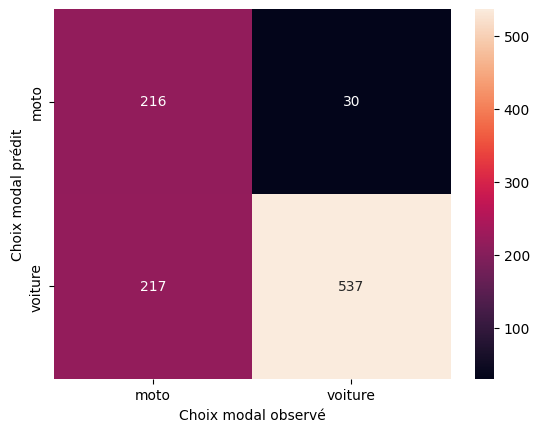

In [19]:
data['y_pred_log']=Log_Reg.predict(X) #la classification prédite par le modèle 
data['class_pred_logreg']=np.where(data['y_pred_log']==1, 'voiture', 'moto')  #Mettre les labels en phase avec notre contexte

#conf_matrix=confusion_matrix(data.ChoixMode, data.class_pred_logreg)
matrice_confusion= pd.crosstab(data.class_pred_logreg,data.ChoixMode, rownames=['Choix modal prédit'], colnames=['Choix modal observé'])
sns.heatmap(matrice_confusion, annot=True, fmt='g')



In [20]:
#confusion_matrix(data.ChoixMode, data.class_pred_logreg)

In [21]:
# Accuracy (Exactitude) calculé plus haut, même valeur
(216+537)/1000

0.753

In [22]:
print('La précision est  de {:.2f}'.format(537/(537+217)))
print('La sensibilité (recall) est de {:.2f}'.format(537/(537+30)))
print('La spécificité (TVN) est de {:.2f}'.format(216/(216+217)))
print('Le score F1 est de {:.2f}'.format(2*(537/(537+217))*537/(537+30)/((537/(537+217))+537/(537+30))))  #2*precision*recall/(precision+recall)


La précision est  de 0.71
La sensibilité (recall) est de 0.95
La spécificité (TVN) est de 0.50
Le score F1 est de 0.81


In [23]:
precision_recall_fscore_support(data.ChoixMode, data.class_pred_logreg)

(array([0.87804878, 0.71220159]),
 array([0.49884527, 0.94708995]),
 array([0.63622975, 0.81302044]),
 array([433, 567], dtype=int64))

In [24]:
print(classification_report(data.ChoixMode,  data.class_pred_logreg))

              precision    recall  f1-score   support

        moto       0.88      0.50      0.64       433
     voiture       0.71      0.95      0.81       567

    accuracy                           0.75      1000
   macro avg       0.80      0.72      0.72      1000
weighted avg       0.78      0.75      0.74      1000



#### Tâche 11:  Représenter la courbe ROC et interpréter l'AUC (Area Under the Curve)
Note: Une courbe ROC (Receiver Operating Characteristic) est un graphe qui montre les performances d'un modèle de classification à tous les seuils de classification. Cette courbe représente deux paramètres: le taux de vrais positifs et le taux de faux positifs. Le courbe ROC résume ainsi  l'arbitrage entre le TVP et le TFP, c'est à dire entre la sensibilité du modèle et (1- spécificité).
En règle générale, entre  0,9 et 1 = Modèle excellent; 0,8–0,9 = bon modèle; 0,7–0,8 = Pas mal; 0,6–0,7 = Médiocre; 0,50–0,6 = Mauvais.

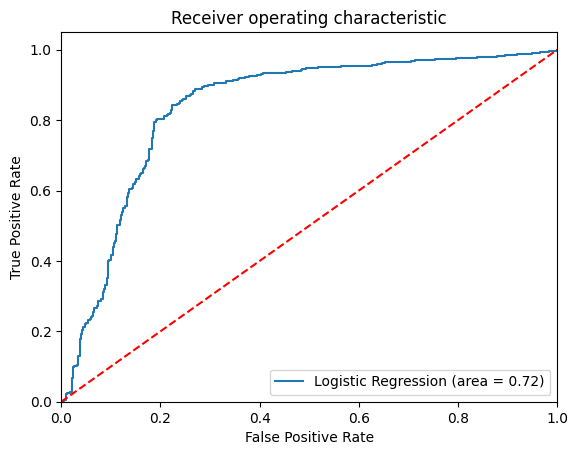

In [25]:
logit_roc_auc = roc_auc_score(y, Log_Reg.predict(X))
fpr, tpr, thresholds = roc_curve(y, Log_Reg.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Régression Logistique (Aire = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux  Positifs')
plt.ylabel('Taux de Vrai Positifs')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
